In [1]:
!pip install ultralytics 
!pip install webcolors==1.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 12.8 MB/s eta 0:00:00a 0:00:01


In [15]:
import cv2
import numpy as np
import datetime
from ultralytics import YOLO
import webcolors
from scipy.spatial import KDTree
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image
from textblob import TextBlob

import matplotlib.pyplot as plt

In [3]:
print(webcolors.__version__)

1.13


In [4]:
image_path = ["/kaggle/input/random-image-on-internet/test_image.png",
              "/kaggle/input/client-test-image/test_image_1.jpg", 
              "/kaggle/input/client-test-image/test_image_2.jpg",
              "/kaggle/input/client-test-image/test_image_3.jpg"]

In [5]:
def LoadImage(image_path):
    # Load image

    image = Image.open(image_path).convert("RGB")
    
    # image to array

    image_to_array = np.array(image)
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    return image_to_array

In [16]:
# Load the BLIP model and processor for image captioning
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

# Precompute the RGB values and corresponding color names
css3_db = {name: webcolors.hex_to_rgb(hex_) for hex_, name in webcolors.CSS3_HEX_TO_NAMES.items()}
names = list(css3_db.keys())
rgb_values = np.array([css3_db[name] for name in names])

# Build a KDTree for fast nearest neighbor search
kd_tree = KDTree(rgb_values)

def get_color_name(rgb_color):
    dist, idx = kd_tree.query(rgb_color)
    return names[idx]

def get_primary_color(image, bbox):
    x, y, w, h = bbox
    roi = image[y:y+h, x:x+w]
    roi = cv2.resize(roi, (10, 10), interpolation=cv2.INTER_AREA)
    avg_color = roi.mean(axis=0).mean(axis=0)
    avg_color = avg_color.astype(int)
    avg_color_rgb = avg_color[::-1].tolist()
    color_name = get_color_name(avg_color_rgb)
    return color_name

def generate_caption(image):
    if image.mode != "RGB":
        image = image.convert(mode="RGB")
    
    # Unconditional image captioning
    inputs = processor(image, return_tensors="pt").to("cuda")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True).strip()
    
    return caption

def generate_vision_record(image: np.array) -> dict:
    yolo_model = YOLO('yolov10n.pt')
    
    results = yolo_model(image)

    detected_objects = []
    activities = []
    object_colors = []
    bounding_boxes = []

    for result in results:
        for bbox, class_id, confidence in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            bbox = bbox.int().tolist()
            class_name = yolo_model.names[int(class_id)]
            detected_objects.append(class_name)

            # Extract the bounding box region and convert to PIL image for image captioning
            cropped_img = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

            # Generate a caption for the cropped image (if needed)
            caption = generate_caption(cropped_img)
            activities.append(caption)  # Using 'activities' to store captions

            color = get_primary_color(image, bbox)
            object_colors.append(color)
            
            bounding_boxes.append(bbox)

    frame_size = image.shape[:2]

    # Convert the entire frame to PIL image for full-frame captioning
    full_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Generate a caption for the entire frame
    frame_summary = generate_caption(full_image)

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")

    vision_record = {
        "Time": timestamp,
        "Objects": detected_objects,
        "Objects Activities": activities,  
        "Object Colors": object_colors,
        "Object Bounding Boxes": bounding_boxes,
        "Frame Size": frame_size,
        "Frame Summary": TextBlob(frame_summary).correct()
    }

    return vision_record

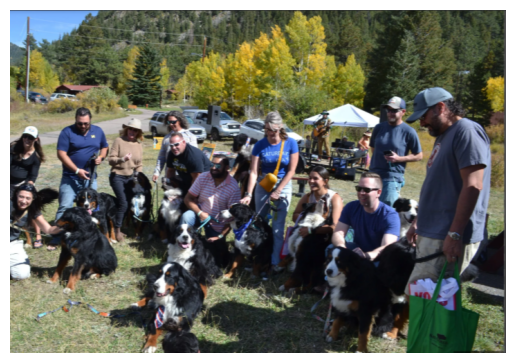

In [17]:
image_1 = LoadImage(image_path=image_path[0])

In [18]:
# Generate the vision record
vision_record = generate_vision_record(image_1)

vision_record


0: 448x640 7 persons, 10 dogs, 15.0ms
Speed: 2.6ms preprocess, 15.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'Time': '2024-08-11 17:55:36.900392',
 'Objects': ['person',
  'dog',
  'person',
  'person',
  'person',
  'dog',
  'person',
  'person',
  'dog',
  'person',
  'dog',
  'dog',
  'dog',
  'dog',
  'dog',
  'dog',
  'dog'],
 'Objects Activities': ['there is a man with blue paint on his face and a dog',
  'dogs playing with a frisbee in a field with people',
  'there is a man with blue paint on his face and a cell phone',
  'there are two men with blue paint on their faces and one man with a hat',
  'there is a man sitting on a bench with a frisbee in his hand',
  'there are two dogs that are sitting next to each other',
  'there is a woman riding a horse with two dogs on it',
  'there is a man with a dog and a man with a mask on',
  'there is a dog that is sitting on a leash next to a person',
  'there is a woman that is walking a dog in the street',
  'there is a dog that is sitting on a blanket with a person',
  'there is a woman with blue paint on her face and a horse',
  'there is

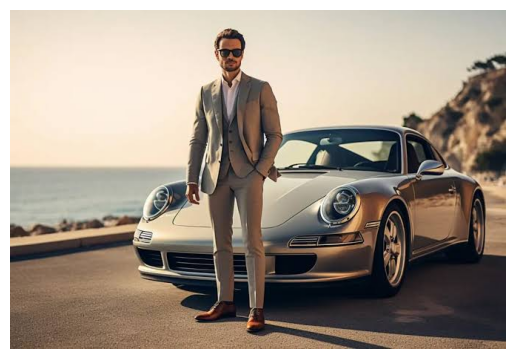

In [19]:
image_2 = LoadImage(image_path=image_path[1])

In [20]:
# Generate the vision record
vision_record = generate_vision_record(image_2)

vision_record


0: 448x640 1 person, 1 car, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


{'Time': '2024-08-11 17:55:39.376184',
 'Objects': ['car', 'person'],
 'Objects Activities': ['arafed man in a suit standing next to a silver car',
  'arafed man in a suit and tie standing next to a car'],
 'Object Colors': ['dimgray', 'slategray'],
 'Object Bounding Boxes': [[161, 156, 644, 390], [238, 26, 368, 431]],
 'Frame Size': (458, 670),
 'Frame Summary': TextBlob("armed man in a suit standing next to a silver sports car")}

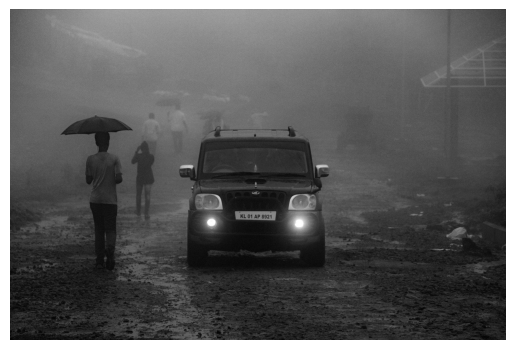

In [21]:
image_3 = LoadImage(image_path=image_path[2])

In [22]:
# Generate the vision record
vision_record = generate_vision_record(image_3)

vision_record


0: 448x640 4 persons, 1 car, 1 truck, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


{'Time': '2024-08-11 17:55:44.802697',
 'Objects': ['person', 'person', 'car', 'truck', 'person', 'person'],
 'Objects Activities': ['there is a man holding an umbrella standing in the rain',
  'arafed image of a person standing in the snow with their back to the camera',
  'arafed vehicle driving on a foggy road with headlights on',
  'arafed vehicle driving on a foggy road with headlights on',
  'arafed man in a black shirt is holding a tennis racket',
  'araffes in the fog on a foggy day with a black and white photo'],
 'Object Colors': ['darkslategray',
  'darkslategray',
  'darkslategray',
  'darkslategray',
  'darkslategray',
  'darkslategray'],
 'Object Bounding Boxes': [[192, 318, 292, 674],
  [312, 334, 374, 537],
  [449, 304, 825, 669],
  [449, 304, 825, 669],
  [407, 251, 459, 373],
  [341, 264, 387, 376]],
 'Frame Size': (853, 1280),
 'Frame Summary': TextBlob("armed vehicle driving down a dirt road with people walking in the background")}

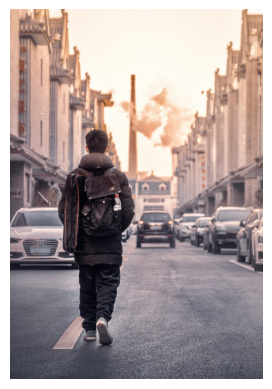

In [23]:
image_4 = LoadImage(image_path=image_path[3])

In [24]:
# Generate the vision record
vision_record = generate_vision_record(image_4)

vision_record


0: 640x448 1 person, 6 cars, 1 backpack, 11.4ms
Speed: 3.2ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


{'Time': '2024-08-11 17:55:50.755029',
 'Objects': ['person', 'car', 'car', 'car', 'car', 'car', 'backpack', 'car'],
 'Objects Activities': ['there is a man walking down the street with a backpack',
  'cars parked in a row on a city street with a blurry background',
  'there is a blurry photo of a car driving down the street',
  'there are many cows that are standing in a row together',
  'araffe walking on the sidewalk with a suitcase and a cell phone',
  'cars are parked on the side of the road in a blurry photo',
  'araffe carrying a black backpack and a blue surfboard',
  'cars parked on the side of the road in a parking lot'],
 'Object Colors': ['gray',
  'gray',
  'gray',
  'gray',
  'dimgray',
  'gray',
  'dimgray',
  'gray'],
 'Object Bounding Boxes': [[168, 415, 436, 1171],
  [669, 681, 840, 847],
  [433, 700, 573, 829],
  [574, 708, 675, 803],
  [1, 681, 222, 892],
  [781, 690, 874, 894],
  [232, 541, 390, 791],
  [622, 717, 699, 826]],
 'Frame Size': (1280, 875),
 'Frame Sum